In [2]:
import matplotlib.pyplot as plt
import numpy as np
from hict.api.ContactMatrixFacet import ContactMatrixFacet
from matrix_visualise import MatrixVisualise
from pathlib import Path
from pyod.models.copod import COPOD
import pandas as pd
from numpy import where
from sklearn.cluster import DBSCAN

In [3]:
chunkFile = ContactMatrixFacet.get_file_descriptor('data/arab_dongX_vs_mopti_2nd_try.hdf5')
ContactMatrixFacet.open_file(chunkFile)
ContactMatrixFacet.load_assembly_from_agp(chunkFile, Path('data/mopti_female_assembly_2.agp'))
res = 10000
matrix = MatrixVisualise.get_matrix(chunkFile, 'scaffold_5', res, False)
scf_desc = chunkFile.scaffold_holder.scaffold_table[1]
matrix_norm = MatrixVisualise.calculate_diag_means(matrix,scf_desc, scf_desc)

/mnt/d/Study/HICT/HICT_Patterns/matrix_visualise.py:75: RuntimeWarning: Mean of empty slice
  [np.nanmean(matrix.diagonal(offset=i))] * (n-abs(i)), k=i


In [3]:
data = pd.DataFrame(range(0, matrix.shape[0]))
data = data.merge(data, how='cross')
data['value'] = pd.Series(matrix.flatten())
data.rename(columns={'0_x':'x','0_y':'y'},inplace=True)
data = data.replace(np.NaN, 0)


data_norm = pd.DataFrame(range(0, matrix_norm.shape[0]))
data_norm = data_norm.merge(data_norm, how='cross')
data_norm['value'] = pd.Series(matrix_norm.flatten())
data_norm.rename(columns={'0_x':'x','0_y':'y'},inplace=True)
data_norm = data_norm.replace(np.NaN, 0)

In [4]:
detector = COPOD()
scores = detector.decision_function(data)
data['scores'] = scores

In [5]:
matrix_scores = np.zeros((data.x.max()+1, data.y.max()+1))
matrix_scores[data.x, data.y] = data.scores

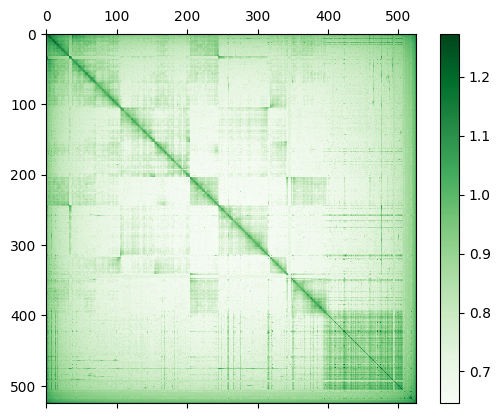

In [6]:
clr_map = MatrixVisualise.get_colormap_diverging(first_quarter=0.249, mid_position=0.250 ,second_quarter=0.251)
fig = plt.figure()
ax = fig.add_subplot(111)
im = ax.matshow(MatrixVisualise.log_matrix(matrix_scores), cmap='Greens')
fig.colorbar(im)
plt.savefig('fig.png', dpi=1000)

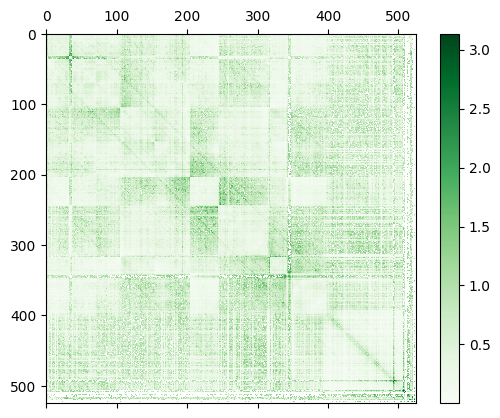

In [7]:
clr_map = MatrixVisualise.get_colormap_diverging(first_quarter=0.249, mid_position=0.250 ,second_quarter=0.251)
fig = plt.figure()
ax = fig.add_subplot(111)
im = ax.matshow(MatrixVisualise.log_matrix(matrix_norm), cmap='Greens')
fig.colorbar(im)

In [ ]:
from sklearn.svm import OneClassSVM

svm = OneClassSVM(kernel='rbf', gamma=0.001, nu=0.03)
svm.fit(data)
pred = svm.predict(data)

anom_index = where(pred==-1)
values = data.iloc[anom_index]
matrix_scores = np.zeros((values.x.max()+1, values.y.max()+1))
matrix_scores[values.x, values.y] = 1
fig = plt.figure()
ax = fig.add_subplot(111)
im = ax.matshow(matrix_scores, cmap='Greens')
fig.colorbar(im)

In [ ]:
svm = OneClassSVM(kernel='rbf', gamma=0.001, nu=0.03)
svm.fit(data_norm)
pred = svm.predict(data_norm)

anom_index = where(pred==-1)
values = data_norm.iloc[anom_index]
matrix_scores = np.zeros((values.x.max()+1, values.y.max()+1))
matrix_scores[values.x, values.y] = 1
fig = plt.figure()
ax = fig.add_subplot(111)
im = ax.matshow(matrix_scores, cmap='Greens')
fig.colorbar(im)

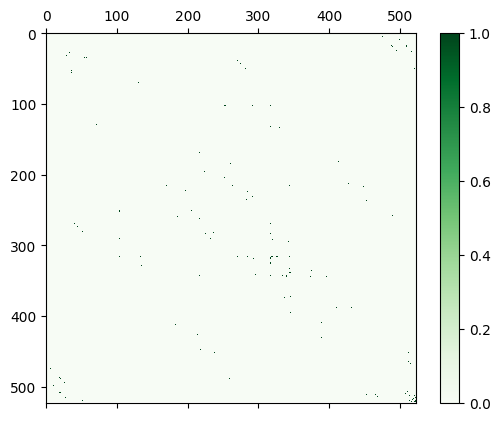

In [4]:
model = DBSCAN(min_samples=5, eps=10)
x = model.fit_predict(data_norm)
anom_index = where(x==-1)
values = data_norm.iloc[anom_index]
matrix_scores = np.zeros((values.x.max()+1, values.y.max()+1))
matrix_scores[values.x, values.y] = 1
fig = plt.figure()
ax = fig.add_subplot(111)
im = ax.matshow(matrix_scores, cmap='Greens')
fig.colorbar(im)

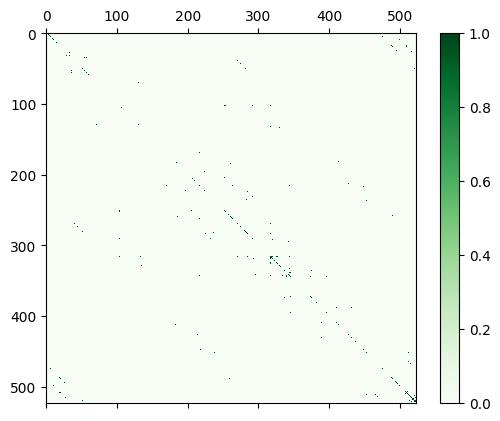

In [5]:
values_centered = values.x[values.x > values.y]
matrix_scores[values_centered, values_centered] = 1
fig = plt.figure()
ax = fig.add_subplot(111)
im = ax.matshow(matrix_scores, cmap='Greens')
fig.colorbar(im)

NameError: name 'values_centered' is not defined

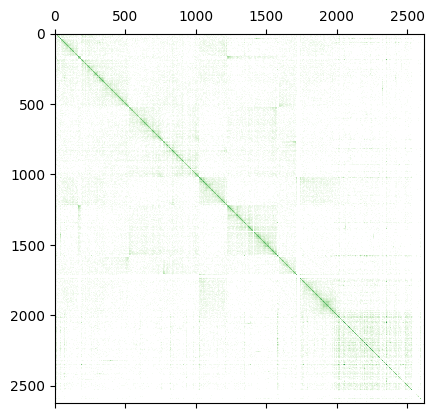

In [38]:
matrix = MatrixVisualise.get_matrix(chunkFile, 'scaffold_5', res, False)
fig = plt.figure()
ax = fig.add_subplot(111)
im = ax.matshow(MatrixVisualise.log_matrix(matrix), cmap='Greens')
plt.scatter(values_centered, values_centered, s=1, c='#E9967A')
fig.colorbar(im)
fig.savefig('res.png', dpi=1000)

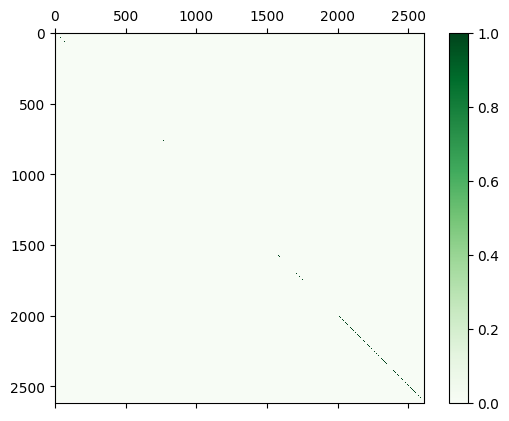

In [3]:
samples = {}
x = 0
np.nan_to_num(matrix_norm, copy=False)
while x < matrix_norm.shape[0]-1:
    features = []
    for i in range(matrix_norm.shape[0]):
        features.append(matrix_norm[x][i]-matrix_norm[x+1][i])
    samples[x] = features
    x+=1
data = pd.DataFrame(samples).transpose()

model = DBSCAN(min_samples=2, eps=100)
x = model.fit_predict(data)
anom_index = where(x==-1)[0]
matrix_scores = np.zeros((max(anom_index)+1, max(anom_index)+1))
matrix_scores[anom_index, anom_index] = 1
fig = plt.figure()
ax = fig.add_subplot(111)
im = ax.matshow(matrix_scores, cmap='Greens')
fig.colorbar(im)

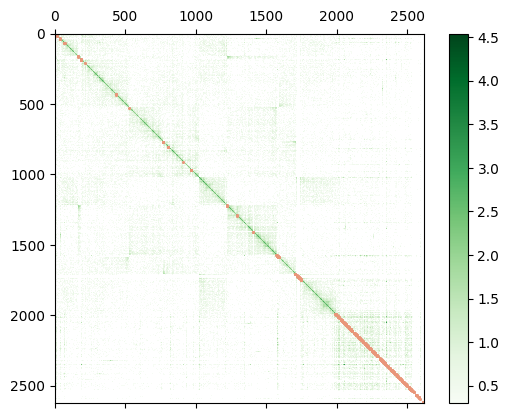

In [4]:
matrix = MatrixVisualise.get_matrix(chunkFile, 'scaffold_5', res, False)
fig = plt.figure()
ax = fig.add_subplot(111)
im = ax.matshow(MatrixVisualise.log_matrix(matrix), cmap='Greens')
values = pd.DataFrame({'x':anom_index, 'y':anom_index})
plt.scatter(values, values, s=1, c='#E9967A')
fig.colorbar(im)
fig.savefig('res.png', dpi=1000)

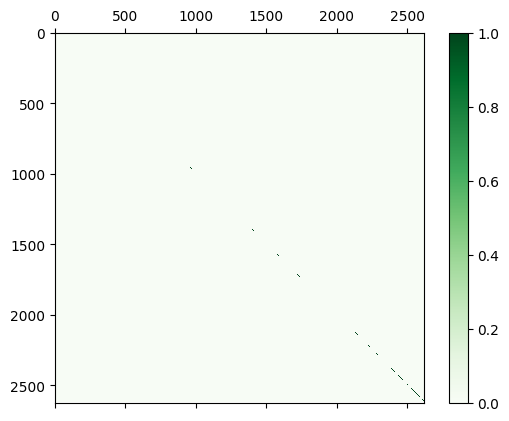

In [5]:
samples = {}
samples['x'] = []
samples['var'] = []
x = 0
while x < matrix_norm.shape[0]-1:
    features = []
    stripe = matrix_norm[x:x+10, max(x-250,0):min(x+250, matrix_norm.shape[0])]
    samples['x'].append(x)
    samples['var'].append(np.nanvar(stripe))
    x+=1
data = pd.DataFrame(samples)

model = DBSCAN(min_samples=15, eps=10)
x = model.fit_predict(data)
anom_index = where(x==-1)
values = data.iloc[anom_index]
matrix_scores = np.zeros((values.x.max()+1, values.x.max()+1))
matrix_scores[values.x, values.x] = 1
fig = plt.figure()
ax = fig.add_subplot(111)
im = ax.matshow(matrix_scores, cmap='Greens')
fig.colorbar(im)

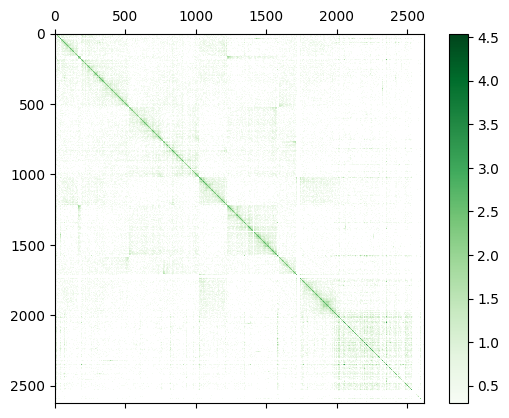

In [41]:
matrix = MatrixVisualise.get_matrix(chunkFile, 'scaffold_5', res, False)
fig = plt.figure()
ax = fig.add_subplot(111)
im = ax.matshow(MatrixVisualise.log_matrix(matrix), cmap='Greens')
plt.scatter(values.x, values.x, s=1, c='#E9967A')
fig.colorbar(im)
fig.savefig('res_var.png', dpi=1000)

sample - окно из двух точек на главной диагонали
feature - x,y, попарные разницы всех точек по вертикали от этих двух (должно быть 6тыс. фичей, если будет слишком много, то можно сливать соседние 2 или 3)

Другая идея - смотреть на распределение точек входящих в полосу например шириной 10

In [24]:
matrix = np.nan_to_num(matrix)

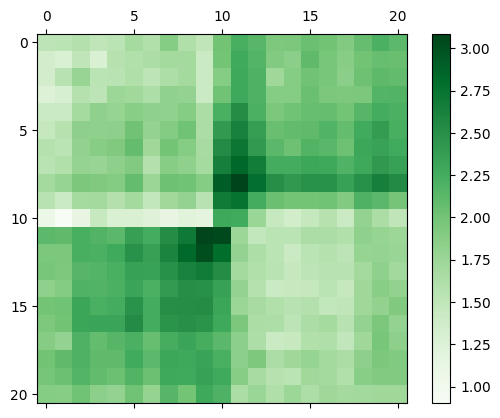

In [49]:
submatrix = MatrixVisualise.get_matrix(chunkFile, 'scaffold_5', 100000, False)[148:169,42:63]
fig = plt.figure()
ax = fig.add_subplot(111)
im = ax.matshow(MatrixVisualise.log_matrix(submatrix), cmap='Greens')
fig.colorbar(im)

(array([0.08380545, 0.29331893, 0.04190273, 0.        , 0.62854091,
        1.38279001, 1.34088654, 0.62854057, 0.12570825, 0.08380541]),
 array([0.90309   , 1.12004268, 1.33699548, 1.55394816, 1.77090096,
        1.98785365, 2.20480633, 2.42175913, 2.63871193, 2.85566449,
        3.07261729]),
 <BarContainer object of 10 artists>)

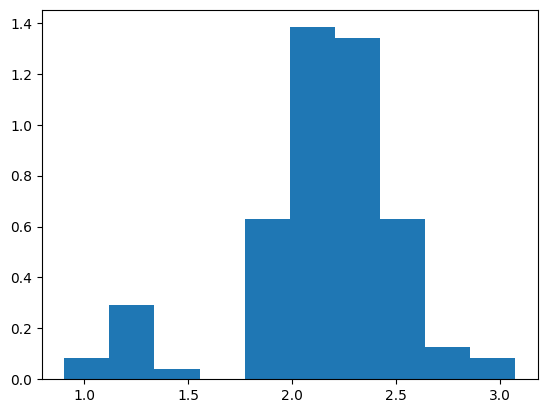

In [62]:
left_up = MatrixVisualise.log_matrix(submatrix[10:21,0:10])
plt.hist(left_up.flatten(), density=True)

In [61]:
submatrix.size

441